### 📘 Lesson 5: Market Model

<div style="display: flex; align-items: center; justify-content: space-between;">
  <div>
    <h3>Course presenters</h3>
    <ul>
      <li><strong>Priyesh Gosai</strong> - Energy Systems Modeler and Training Coordinator</li>
      <li><strong>Dr. Fabian Hofmann</strong> - Senior Optimization and Energy System Modelling Expert</li>
    </ul>
  </div>
  <div>
    <a href="https://openenergytransition.org/index.html">
      <img src="https://openenergytransition.org/assets/img/oet-logo-red-n-subtitle.png" height="60" alt="OET">
    </a>
  </div>
</div>


#### 🎯 Learning Objectives  



* Run a demonstration model using real data. 
* Solve the Day ahead and intra day model. 
* Analyse the results.

---

#### 📈 Market Model

In [ ]:
import pypsa
import pandas as pd
import numpy as np
from training_scripts import *
import matplotlib.pyplot as plt

import os
import shutil


In [30]:
input_file_name = 'data/Lesson6_model.xlsx'
path = convert_selected_sheets_to_csv(input_file_name, 'lesson6_csv_folder')

INFO:root:Converted snapshots to CSV.
INFO:root:Converted buses to CSV.
INFO:root:Converted carriers to CSV.
INFO:root:Converted generators to CSV.
INFO:root:Converted links to CSV.
INFO:root:Converted loads to CSV.
INFO:root:Converted storage_units to CSV.
INFO:root:Converted loads-p_set to CSV.
INFO:root:Converted generators-p_max_pu to CSV.
INFO:root:Converted storage_units-inflow to CSV.
INFO:root:Conversion complete. CSV files are saved in 'lesson6_csv_folder'
INFO:root:Excel file closed successfully.


In [31]:
network = pypsa.Network(path)

INFO:pypsa.io:Imported network lesson6_csv_folder has buses, carriers, generators, links, loads, storage_units


In [32]:
dispatchable_generators = network.generators[network.generators.carrier.isin(['coal', 'biomass', 'gas'])].index.tolist()

network.generators.loc[network.generators["carrier"] == "coal", "p_min_pu"] = 0.1
network.generators.loc[network.generators["carrier"] == "biomass", "p_min_pu"] = 0.1

network.generators.loc[network.generators["carrier"] == "coal", "ramp_limit_up"] = 0.25
network.generators.loc[network.generators["carrier"] == "biomass", "ramp_limit_up"] = 0.25

network.generators.loc[network.generators["carrier"] == "coal", "ramp_limit_down"] = 0.25
network.generators.loc[network.generators["carrier"] == "biomass", "ramp_limit_down"] = 0.25

network.generators.loc[network.generators["carrier"] == "coal", "min_up_time"] = 4
network.generators.loc[network.generators["carrier"] == "biomass", "min_up_time"] = 4

network.generators.loc[network.generators["carrier"] == "coal", "min_down_time"] = 10
network.generators.loc[network.generators["carrier"] == "biomass", "min_down_time"] = 10


💧 **Setting Water Availability for Hydropower Plants**


⚡ **Modeling Demand Side Management (DSM)**  





In [33]:
network.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2019-12-31 14:00:00', '2019-12-31 15:00:00',
               '2019-12-31 16:00:00', '2019-12-31 17:00:00',
               '2019-12-31 18:00:00', '2019-12-31 19:00:00',
               '2019-12-31 20:00:00', '2019-12-31 21:00:00',
               '2019-12-31 22:00:00', '2019-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=43819, freq=None)

In [34]:
marginal_costs_dict = {} 

# Ensure the 'monte_carlo' directory exists
monte_carlo_dir = "monte_carlo"
os.makedirs(monte_carlo_dir, exist_ok=True)

# Define the number of iterations and the step size (3 days)
num_iterations = 10
days_per_run = 3

# Loop through the iterations
for i in range(num_iterations):
    # Create a copy of the original network
    network_copy = network.copy()  # Assuming 'network' is your base PyPSA network

    # Define the time window for the current iteration
    start_index = i * days_per_run * 24  # Assuming hourly resolution
    end_index = start_index + (days_per_run * 24)
    
    # Ensure we do not exceed available snapshots
    if end_index > len(network.snapshots):
        print(f"Skipping iteration {i} as it exceeds available snapshots.")
        break

    # Select snapshots for this iteration
    network_copy.snapshots = network.snapshots[start_index:end_index]

    # Solve the network for the selected period
    network_copy.optimize()



    # Make a copy of the marginal price data
    df_marginal_prices = network_copy.buses_t.marginal_price.copy()

    # Generate a new datetime index starting from 1st Jan 2015 with the same length as df
    new_index = pd.date_range(start="2015-01-01 00:00:00", periods=len(df_marginal_prices), freq="h")

    # Assign the new index to df
    df_marginal_prices.index = new_index




    marginal_costs_dict[f"run_{i}"] = df_marginal_prices

    # Save the solved network
    network_copy.export_to_netcdf(os.path.join(monte_carlo_dir, f"solved_network_{i}.nc"))

    print(f"Run {i+1} completed and stored in {monte_carlo_dir}")


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 74.53it/s]
INFO:linopy.io: Writing time: 0.84s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31680 primals, 119168 duals
Objective: 1.54e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.io:Exported network 'solved_network_0.nc' contains: loads, carriers, storage_units, buses, links, generator

Run 1 completed and stored in monte_carlo


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 70.15it/s]
INFO:linopy.io: Writing time: 0.87s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31680 primals, 119168 duals
Objective: 2.57e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.io:Exported network 'solved_network_1.nc' contains: loads, carriers, storage_units, buses, links, generator

Run 2 completed and stored in monte_carlo


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 72.72it/s]
INFO:linopy.io: Writing time: 0.84s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31680 primals, 119168 duals
Objective: 1.74e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.io:Exported network 'solved_network_2.nc' contains: loads, carriers, storage_units, buses, links, generator

Run 3 completed and stored in monte_carlo


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 74.55it/s]
INFO:linopy.io: Writing time: 0.85s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31680 primals, 119168 duals
Objective: 5.14e+08
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.io:Exported network 'solved_network_3.nc' contains: loads, carriers, storage_units, buses, links, generator

Run 4 completed and stored in monte_carlo


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 71.85it/s]
INFO:linopy.io: Writing time: 0.86s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31680 primals, 119168 duals
Objective: 9.59e+08
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.io:Exported network 'solved_network_4.nc' contains: loads, carriers, storage_units, buses, links, generator

Run 5 completed and stored in monte_carlo


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 72.72it/s]
INFO:linopy.io: Writing time: 0.83s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31680 primals, 119168 duals
Objective: 2.28e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.io:Exported network 'solved_network_5.nc' contains: loads, carriers, storage_units, buses, links, generator

Run 6 completed and stored in monte_carlo


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 73.61it/s]
INFO:linopy.io: Writing time: 0.88s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31680 primals, 119168 duals
Objective: 3.52e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.io:Exported network 'solved_network_6.nc' contains: loads, carriers, storage_units, buses, links, generator

Run 7 completed and stored in monte_carlo


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 66.54it/s]
INFO:linopy.io: Writing time: 0.84s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31680 primals, 119168 duals
Objective: 3.10e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.io:Exported network 'solved_network_7.nc' contains: loads, carriers, storage_units, buses, links, generator

Run 8 completed and stored in monte_carlo


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 74.82it/s]
INFO:linopy.io: Writing time: 0.84s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31680 primals, 119168 duals
Objective: 2.83e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.io:Exported network 'solved_network_8.nc' contains: loads, carriers, storage_units, buses, links, generator

Run 9 completed and stored in monte_carlo


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 72.71it/s]
INFO:linopy.io: Writing time: 0.86s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31680 primals, 119168 duals
Objective: 1.85e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:pypsa.io:Exported network 'solved_network_9.nc' contains: loads, carriers, storage_units, buses, links, generator

Run 10 completed and stored in monte_carlo


In [47]:
marginal_costs_dict['run_5']

,BE,DK,FR,LU,NO,SE,DE,NL
2015-01-01 00:00:00,1004.0,0.171,1006.0,0.15,0.15,0.160,0.158,0.78
2015-01-01 01:00:00,1004.0,0.171,1006.0,0.15,0.15,0.160,0.158,0.78
2015-01-01 02:00:00,1004.0,0.171,1006.0,0.15,0.15,0.160,0.158,0.78
2015-01-01 03:00:00,1004.0,0.171,1006.0,0.15,0.15,0.160,0.158,0.78
2015-01-01 04:00:00,1004.0,0.171,1006.0,0.15,0.15,0.160,0.158,0.78
...,...,...,...,...,...,...,...,...
2015-01-03 19:00:00,1004.0,2.010,1006.0,0.15,0.15,1.999,5.870,2.63
2015-01-03 20:00:00,1004.0,2.010,1006.0,0.15,0.15,1.999,5.430,2.63
2015-01-03 21:00:00,1004.0,2.010,1006.0,0.15,0.15,1.999,5.380,2.29
2015-01-03 22:00:00,1004.0,2.010,1006.0,0.15,0.15,1.999,5.660,1.63


In [49]:
average_df = pd.concat(marginal_costs_dict.values(), axis=0).groupby(level=0).mean()

std_dev_df = pd.concat(marginal_costs_dict.values(), axis=0).groupby(level=0).std()

In [50]:
average_df

,BE,DK,FR,LU,NO,SE,DE,NL
2015-01-01 00:00:00,803.3621,1.0198,906.558,0.15,0.15,1.0088,2.4304,1.2370
2015-01-01 01:00:00,803.3621,1.0068,906.148,0.15,0.15,0.9958,2.2104,1.0720
2015-01-01 02:00:00,803.3542,1.1798,906.051,0.15,0.15,1.1688,2.1054,1.0450
2015-01-01 03:00:00,803.3180,1.2121,905.742,0.15,0.15,1.2011,2.1368,1.0430
2015-01-01 04:00:00,803.3371,1.2033,806.174,0.15,0.15,1.1923,2.1460,1.0450
...,...,...,...,...,...,...,...,...
2015-01-03 19:00:00,904.2810,2.1955,1006.000,0.15,0.15,101.7636,4.5157,3.5699
2015-01-03 20:00:00,904.2120,2.0325,1006.000,0.15,0.15,2.4636,3.8673,3.2612
2015-01-03 21:00:00,904.1080,1.7482,1006.000,0.15,0.15,1.7372,3.5769,2.8668
2015-01-03 22:00:00,904.0270,1.5446,906.558,0.15,0.15,1.5336,3.3626,2.3438


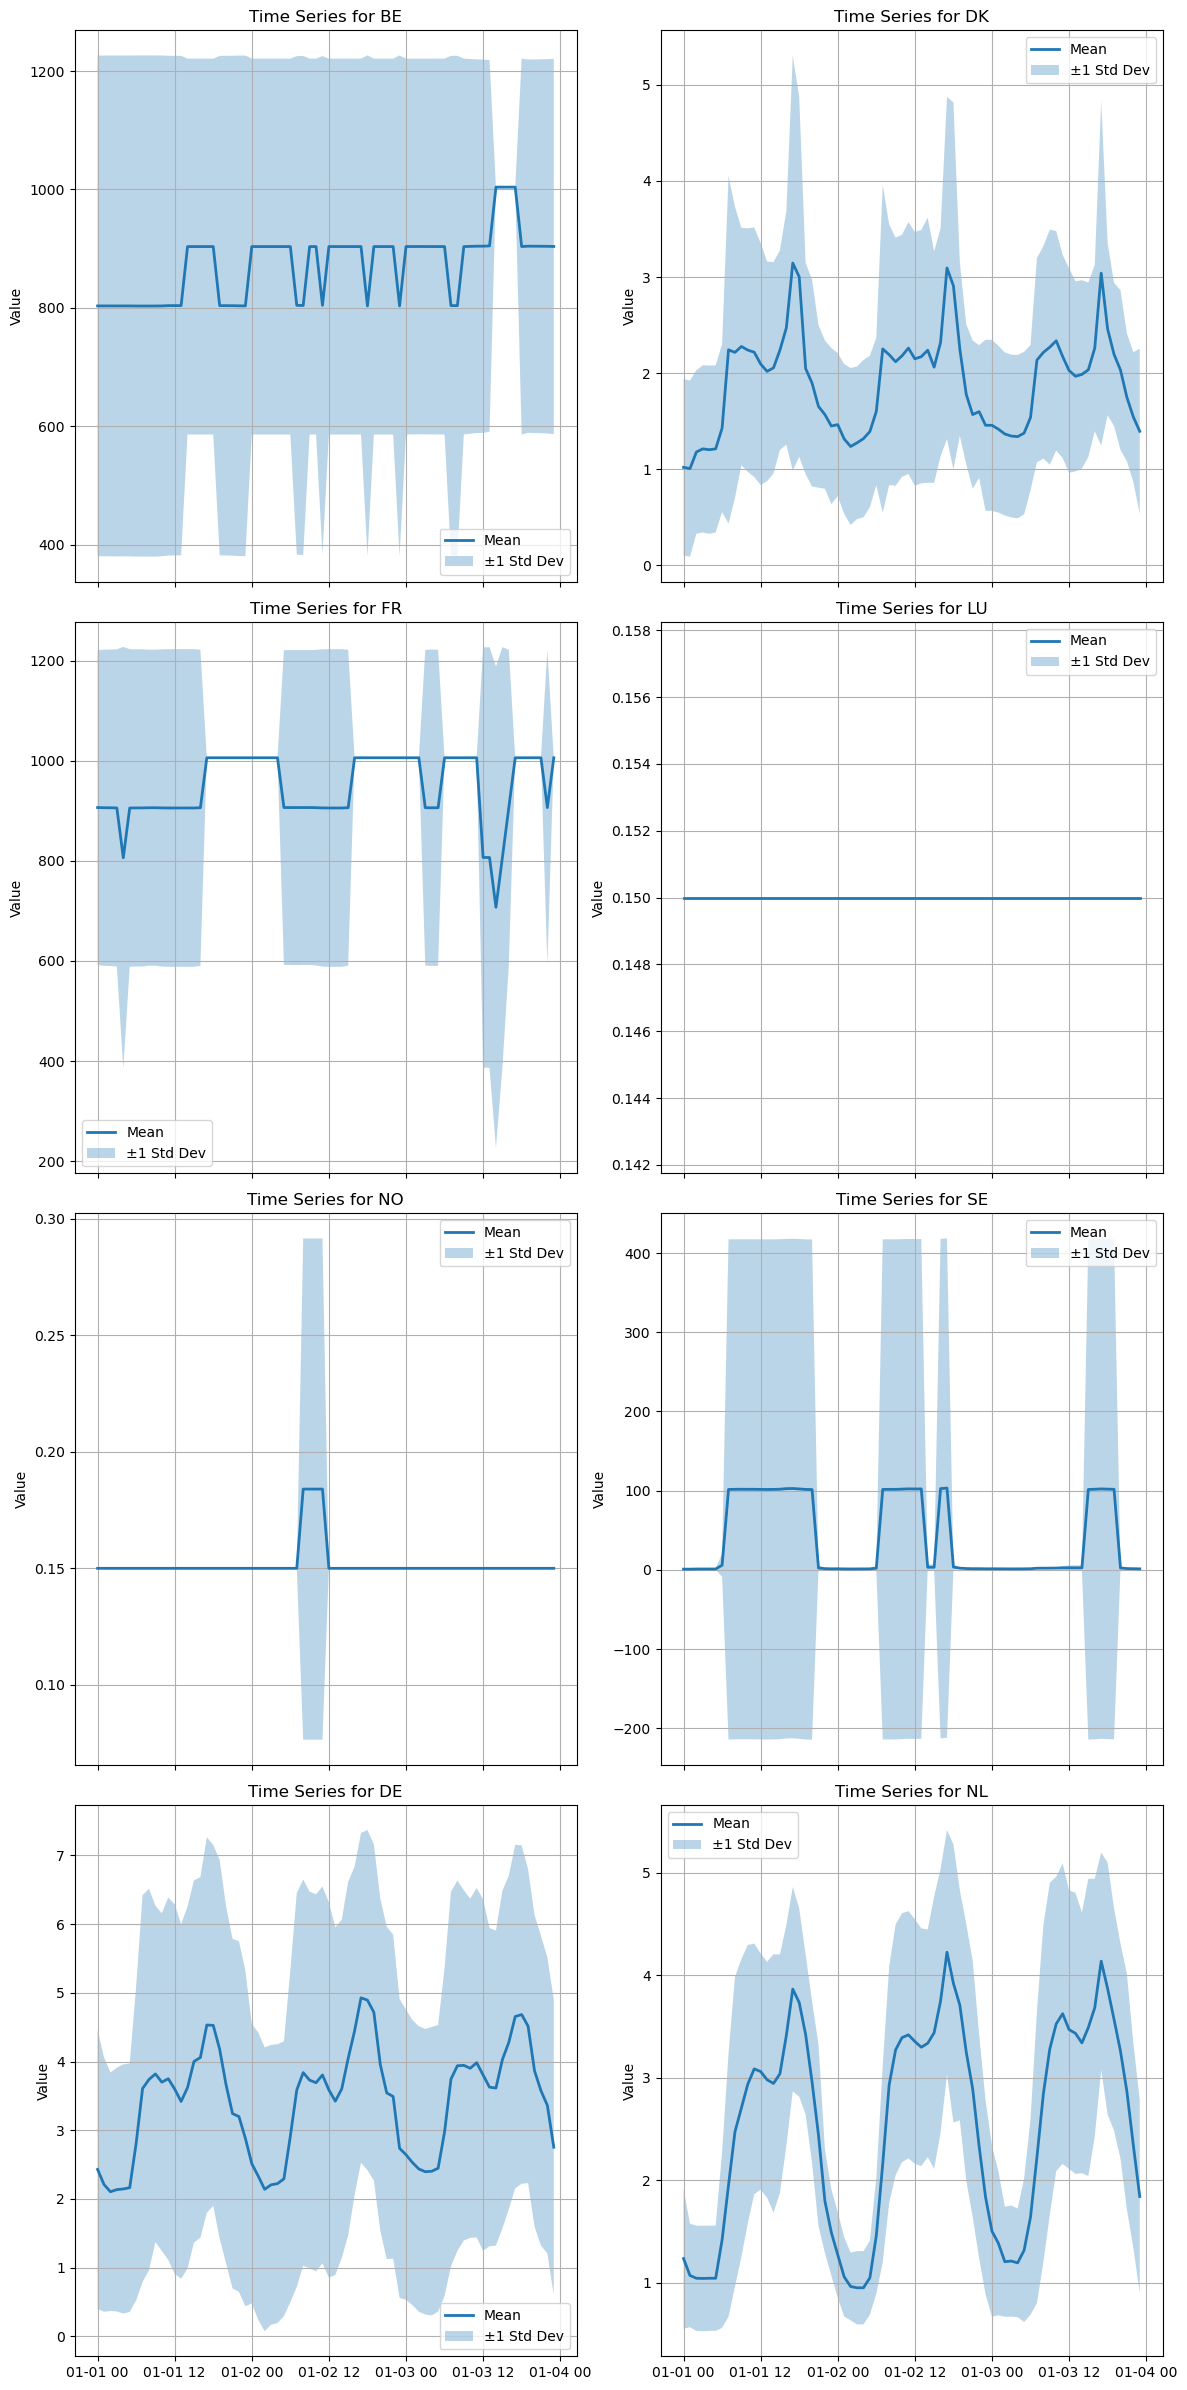

In [ ]:


# Create a 2-column layout for the plots
num_columns = 2
num_rows = int(np.ceil(len(average_df.columns) / num_columns))

fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 6 * num_rows), sharex=True)
axes = axes.flatten()  # Flatten in case of single-row case

# Plot each column separately
for i, column in enumerate(average_df.columns):
    ax = axes[i]
    ax.plot(average_df.index, average_df[column], label="Mean", linewidth=2)
    ax.fill_between(
        average_df.index,
        average_df[column] - std_dev_df[column],
        average_df[column] + std_dev_df[column],
        alpha=0.3,
        label="±1 Std Dev",
    )
    
    ax.set_title(f"Time Series for {column}")
    ax.set_ylabel("Value")
    ax.legend()
    ax.grid(True)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


###
---